In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import xarray as xr
import matplotlib.patches as mpatches
import os
from lib import conversion
import matplotlib.lines as mlines
import stageemi.dev.geojson_shapefile as geojson_shapefile
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
def get_legend(code_compas, code_compas_asym, code_agat_asym, code_agat):
    file_CodesWWMF = '../utils/CodesWWMF.csv'
    df2             = pd.read_csv(file_CodesWWMF,sep=',')
    Code_WME       = df2['Code WME'].to_numpy()
    Code_WWMF      = df2['Code WWMF'].to_numpy()
    Code_W1        = df2['Code W1'].to_numpy()
    legende_WWMF   = df2['Legende WWMF'].to_numpy()
    legende_WME    = df2['Legende WME'].to_numpy()
    legende_W1     = df2['Legende W1'].to_numpy()

    leg_compas = np.unique(legende_WME[Code_WME==code_compas])[0]
    leg_compas_asym = np.unique(legende_WME[Code_WME==code_compas_asym])[0]
    leg_agat_asym = np.unique(legende_W1[Code_W1==code_agat_asym])[0]
    leg_agat      = np.unique(legende_W1[Code_W1==code_agat])[0]
    return(leg_compas,leg_compas_asym,leg_agat_asym,leg_agat)

def  get_color(code_compas, code_compas_asym, code_agat_asym, code_agat,newcolors_agat, newcolors_compas):
    df2             = pd.read_csv(file_CodesWWMF,sep=',')
    Code_WME       = np.unique(df2['Code WME'].to_numpy())
    Code_WWMF      = np.unique(df2['Code WWMF'].to_numpy())
    Code_W1        = np.unique(df2['Code W1'].to_numpy())
    legende_WWMF   = np.unique(df2['Legende WWMF'].to_numpy())
    legende_WME    = np.unique(df2['Legende WME'].to_numpy())
    legende_W1     = np.unique(df2['Legende W1'].to_numpy())

    compas_color = newcolors_compas.values[Code_WME==code_compas][0]
    compas_asym_color = newcolors_compas.values[Code_WME==code_compas_asym][0]
    agat_color = newcolors_agat.values[Code_W1==code_agat][0]
    agat_asym_color = newcolors_agat.values[Code_W1==code_agat_asym][0]
    
    return(compas_color, compas_asym_color,agat_asym_color ,agat_color ) 

# plot des zones d'intérêts pour l'agrégation 

In [4]:
plt.rcParams.update({'font.size': 18})
# dir_fig = '../../../figures/bilan_agregation/'
dir_fig = '../figures/agregation/'
dir_csv = '../zonageWME/'
file_CodesWWMF = '../utils/CodesWWMF.csv'
date = '2020012600'
# date = '2020030600'
# echeance = 30 
# dep_id = '41'
# index_zone = 5

if date == '2020012600':
    echeance_dict = {
#         '38':[3]
        '34':[1]#,1,4,6],
#         '29':[13]
    }
    index_zone_dict ={
# #         '41':[2,0],
        '34':[0]#,0,1,0],
# #         '38':[0,1],
#         '29':[0],
#         '38':[0]
    }

if date == '2020030600':
    echeance_dict = {
        '38':[4]#,29,4],#[3,29],
#         '29':[5]
#         '34':[], 
#         '41':[]
    }
    index_zone_dict ={
#         '41':[],
#         '34':[],
        '38':[2]#,1,2],
#         '29':[0]
    }


In [5]:
file_CodesWWMF = '../utils/CodesWWMF.csv'
df2             = pd.read_csv(file_CodesWWMF,sep=',')
clevs_dict = {
    'W1': np.unique(df2['Code W1'].to_numpy()),
    'WME': np.unique(df2['Code WME'].to_numpy()) 
}

newcolors_agat, newcolors_rgb = geojson_shapefile.colorbar_definition_wwmf(25,'viridis',variable = 'W1')
newcolors_compas, newcolors_rgb = geojson_shapefile.colorbar_definition_wwmf(19,'viridis',variable = 'WME')



../WWMF/20200126000000__PG0PAROME__WWMF__EURW1S100______GRILLE____0_48_1__SOL____GRIB2.nc
[1]


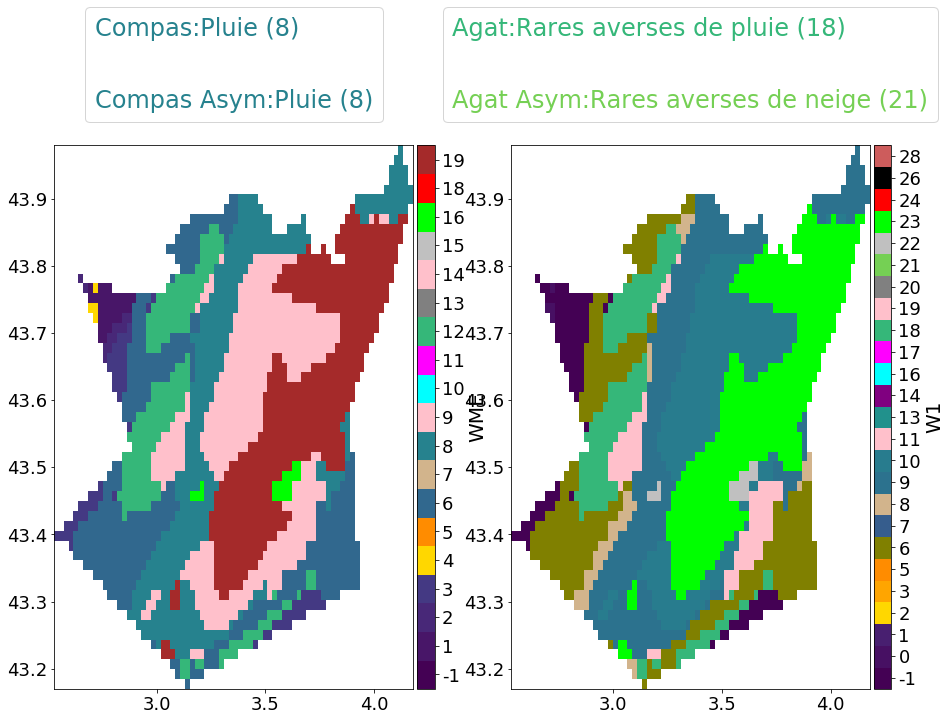

In [97]:
''' lecture arome '''
for dep_id in echeance_dict.keys():
    echeance_list = echeance_dict[dep_id]
    fname = "../WWMF/" + date+'0000__PG0PAROME__'+'WWMF'+'__EURW1S100______GRILLE____0_48_1__SOL____GRIB2.nc'
    print(fname)

    ds = xr.open_dataset(fname,chunks={"step":1}).isel(step = echeance_list)
    ds['latitude']  = ds['latitude'].round(5)
    ds['longitude'] = ds['longitude'].round(5)
    print(echeance_list)
    '''lecture masque'''
    fname_out = '../GeoData/zones_sympo_multiples/'+dep_id+'_mask_zones_sympos.nc'
    if os.path.exists(fname_out): 
        ds_mask = xr.open_dataset(fname_out,chunks={"id":1})
        ds_mask["latitude"]  = ds_mask["latitude"].round(5)
        ds_mask["longitude"] = ds_mask["longitude"].round(5)

    for icheance,echeance in enumerate(echeance_dict[dep_id]):
        
        index_zone = index_zone_dict[dep_id][icheance]
        ''' lecture fichier resultat '''
        fname_csv_ini = dir_csv+ 'v2_'+dep_id+'_'+date+'_'+str(echeance)+'.csv'
        df = pd.read_csv(fname_csv_ini)
        id_zone = df.iloc[index_zone]['zone']

        ds_dep_tot = (ds*ds_mask.mask.sel(id=id_zone).drop("id"))
        if date == '2020030600':
            ds_dep_tot = ds_dep_tot.rename({'paramId_0':'unknown'})
        # conversion
        for name in ['compas','agat']:
            ds_dep_tot = conversion (ds_dep_tot,name)            
        # label pour le plot
        
        leg_compas,leg_compas_asym,leg_agat_asym,leg_agat = get_legend(df.iloc[index_zone]['compas'], 
                                        df.iloc[index_zone]['compas_asym'], df.iloc[index_zone]['agat_asym'], df.iloc[index_zone]['agat'])
        compas_color, compas_asym_color,agat_asym_color ,agat_color = get_color(df.iloc[index_zone]['compas'],  
                                        df.iloc[index_zone]['compas_asym'], df.iloc[index_zone]['agat_asym'], 
                                        df.iloc[index_zone]['agat'],newcolors_agat, newcolors_compas)


        fig,axes = plt.subplots(nrows = 1, ncols=2,figsize  = (15,10))
        ax       = axes.flat         
#         fig,ax = plt.subplots(nrows = 1, ncols=1)      
        var2plot_lst = ['wme_arr','w1_arr'] #['unknown','wme_arr','w1_arr']
        title_lst    = ['WME','W1'] #['WWMF','WME','W1']
        varmin_lst   = [-1,-1]     #[0,1,0]
        varmax_lst   = [19,28]    #[99,19,30]
        N_lst        = [19,25]    # nombre de niveaux 
        for iplot in range(len(title_lst)):
            var2plot = ds_dep_tot[var2plot_lst[iplot]].isel(step = 0).where(ds_mask.mask.sel(id=id_zone)==1,drop=True)
            newcolors, newcolors_rgb = geojson_shapefile.colorbar_definition_wwmf(N_lst[iplot],'viridis',variable = title_lst[iplot])
            divider = make_axes_locatable(ax[iplot])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            newcmp = matplotlib.colors.ListedColormap(newcolors.values)
            bounds   = np.linspace(0,N_lst[iplot],N_lst[iplot]+1)
            ticks_new = bounds[::-1]+0.5 
            norm = matplotlib.colors.BoundaryNorm(bounds, newcmp.N)#len(colors[1:-1]))
            cbar = matplotlib.colorbar.ColorbarBase(cax,cmap=newcmp, boundaries=bounds,ticks=ticks_new)   
            cbar.ax.set_yticklabels(clevs_dict[title_lst[iplot]][::-1])
            cbar.ax.tick_params(labelsize=18)
            cbar.set_label(title_lst[iplot],fontsize = 20)
            varmin   = varmin_lst[iplot]
            varmax   = varmax_lst[iplot]     

            im = ax[iplot].imshow(var2plot,cmap=newcmp,vmin = varmin, vmax=varmax,aspect='auto',
                      extent = [ds_dep_tot.longitude.values.min(),ds_dep_tot.longitude.values.max(),ds_dep_tot.latitude.values.min(),ds_dep_tot.latitude.values.max()])

            ax[iplot].set_title('')

            if iplot == 0: 
                handles = [ mlines.Line2D([], [], color=compas_color,
                                    label= 'Compas:{} ({})'.format(leg_compas,df.iloc[index_zone]['compas'])),
                           mlines.Line2D([], [], color=compas_asym_color,
                                    label= 'Compas Asym:{} ({})'.format(leg_compas_asym,df.iloc[index_zone]['compas_asym'])) 
                ]
            if iplot==1:
                handles = [mlines.Line2D([], [], color=agat_color,
                                            label= 'Agat:{} ({})'.format(leg_agat,df.iloc[index_zone]['agat'])),                            
                     mlines.Line2D([], [], color=agat_asym_color,
                                            label= 'Agat Asym:{} ({})'.format(leg_agat_asym,df.iloc[index_zone]['agat_asym']))        
                ]
                                
        
            leg = ax[iplot].legend(handles=handles, bbox_to_anchor=(0.5, 1.02),
                               loc='lower center',labelspacing =2,fontsize = 24,
                                   handlelength=0, handletextpad=0, fancybox=True)
#             leg = ax[iplot].legend(handles=handles, bbox_to_anchor=(0., 1.02, 1., .102),
#                                loc='lower left',labelspacing =2,fontsize = 23,mode="expand",
#                                    handlelength=0, handletextpad=0, fancybox=True)
           
            for line, text in zip(leg.get_lines(), leg.get_texts()):
                text.set_color(line.get_color())
            
#         for item in leg.legendHandles:
#             item.set_visible(False)
            
#         fig.suptitle(label,y=1.05,fontsize = 18)
#         fig.tight_layout()
#         fig.savefig(dir_fig+'v3_'+dep_id+'_'+date+'_'+str(echeance)+'_'+str(index_zone)+'.png',bbox_inches='tight',dpi=400)
#         plt.clf()
#         plt.close('all')


array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       18, 19], dtype=int64)

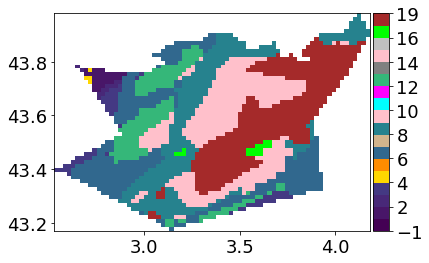

In [101]:
iplot =0
var2plot = ds_dep_tot.wme_arr.isel(step = 0).where(ds_mask.mask.sel(id=id_zone)==1,drop=True)
fig,ax = plt.subplots(nrows=1,ncols=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
newcolors, newcolors_rgb = geojson_shapefile.colorbar_definition_wwmf(19,'viridis',variable = title_lst[iplot])

newcmp = matplotlib.colors.ListedColormap(newcolors.values)
bounds   = clevs_dict[title_lst[iplot]] #np.linspace(-1,N_lst[iplot],N_lst[iplot]+1) # 

# bounds_ext = [[bounds[0]-1]+list(bounds)+[bounds[-1]+1]]#[contour_in.levels[0]-1] + list(bounds) +[contour_in.levels[-1]+1]
# bounds_ext = [list(bounds)+[bounds[-1]+1]]
# print(bounds_ext)
norm = matplotlib.colors.BoundaryNorm(list(bounds), newcmp.N) 
# cbar = matplotlib.colorbar.ColorbarBase(cax,norm=norm,cmap=newcmp,extend='both',
#                                         boundaries=bounds_ext,ticks=bounds)
# sys.exit()
im = ax.imshow(var2plot,cmap=newcmp,aspect='auto',norm=norm,
          extent = [ds_dep_tot.longitude.values.min(),ds_dep_tot.longitude.values.max(),ds_dep_tot.latitude.values.min(),ds_dep_tot.latitude.values.max()])

cbar = fig.colorbar(im,cax=cax) 
# ticks_new = bounds # +0.5 # bounds[:-1:1]+0.5 
# cbar.ax.set_yticklabels(ticks_new)
# cbar.ax.tick_params(labelsize=12)
# ax1 = fig.add_axes([0.05, 0.12, 0.2, 0.87])
clevs_dict[title_lst[iplot]]

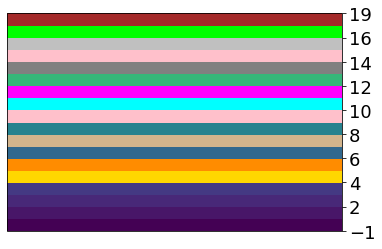

In [96]:
fig,ax = plt.subplots(nrows=1,ncols=1)
newcolors, newcolors_rgb = geojson_shapefile.colorbar_definition_wwmf(19,'viridis',variable = title_lst[iplot])
cmap  = matplotlib.colors.ListedColormap(newcolors.values)

bounds   = clevs_dict[title_lst[iplot]] #np.linspace(-1,N_lst[iplot],N_lst[iplot]+1) # 
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb3 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,norm=norm)


In [ ]:
sys.exit()

In [ ]:
''' lecture arome '''
for dep_id in echeance_dict.keys():
    echeance_list = echeance_dict[dep_id]
    fname = "../WWMF/" + date+'0000__PG0PAROME__'+'WWMF'+'__EURW1S100______GRILLE____0_48_1__SOL____GRIB2.nc'
    print(fname)

    ds = xr.open_dataset(fname,chunks={"step":1}).isel(step = echeance_list)
    ds['latitude']  = ds['latitude'].round(5)
    ds['longitude'] = ds['longitude'].round(5)
    print(echeance_list)
    '''lecture masque'''
    fname_out = '../GeoData/zones_sympo_multiples/'+dep_id+'_mask_zones_sympos.nc'
    if os.path.exists(fname_out): 
        ds_mask = xr.open_dataset(fname_out,chunks={"id":1})
        ds_mask["latitude"]  = ds_mask["latitude"].round(5)
        ds_mask["longitude"] = ds_mask["longitude"].round(5)

    for icheance,echeance in enumerate(echeance_dict[dep_id]):
        
        index_zone = index_zone_dict[dep_id][icheance]
        ''' lecture fichier resultat '''
        fname_csv_ini = dir_csv+ 'v2_'+dep_id+'_'+date+'_'+str(echeance)+'.csv'
        df = pd.read_csv(fname_csv_ini)
        id_zone = df.iloc[index_zone]['zone']

        ds_dep_tot = (ds*ds_mask.mask.sel(id=id_zone).drop("id"))
        if date == '2020030600':
            ds_dep_tot = ds_dep_tot.rename({'paramId_0':'unknown'})
        # conversion
        for name in ['compas','agat']:
            ds_dep_tot = conversion (ds_dep_tot,name)            
        # label pour le plot
        
        leg_compas,leg_compas_asym,leg_agat_asym,leg_agat = get_legend(df.iloc[index_zone]['compas'], 
                                        df.iloc[index_zone]['compas_asym'], df.iloc[index_zone]['agat_asym'], df.iloc[index_zone]['agat'])
        compas_color, compas_asym_color,agat_asym_color ,agat_color = get_color(df.iloc[index_zone]['compas'],  
                                        df.iloc[index_zone]['compas_asym'], df.iloc[index_zone]['agat_asym'], 
                                        df.iloc[index_zone]['agat'],newcolors_agat, newcolors_compas)


        fig,axes = plt.subplots(nrows = 1, ncols=2,figsize  = (15,5))
        ax       = axes.flat         
#         fig,ax = plt.subplots(nrows = 1, ncols=1)      
        var2plot_lst = ['wme_arr','w1_arr'] #['unknown','wme_arr','w1_arr']
        title_lst    = ['WME','W1'] #['WWMF','WME','W1']
        varmin_lst   = [-1,-1]     #[0,1,0]
        varmax_lst   = [19,28]    #[99,19,30]
        N_lst        = [19,25]    # nombre de niveaux 
        for iplot in range(len(title_lst)):
            var2plot = ds_dep_tot[var2plot_lst[iplot]].isel(step = 0).where(ds_mask.mask.sel(id=id_zone)==1,drop=True)
            newcolors, newcolors_rgb = geojson_shapefile.colorbar_definition_wwmf(N_lst[iplot],'viridis',variable = title_lst[iplot])
            cmap     = matplotlib.colors.ListedColormap(newcolors.values)
            varmin   = varmin_lst[iplot]
            varmax   = varmax_lst[iplot]     
            clevs    = clevs_dict[title_lst[iplot]]
            cs       = var2plot.plot.imshow(ax = ax[iplot],cmap=cmap,vmin = varmin, vmax=varmax,
                                            cbar_kwargs={'label':title_lst[iplot]}) #cbar_kwargs 
            ax[iplot].set_title('')
        compas_line = mlines.Line2D([], [], color=compas_color,
                                    label= 'Compas:{} ({})'.format(leg_compas,df.iloc[index_zone]['compas']))
        compas_asym_line = mlines.Line2D([], [], color=compas_asym_color,
                                    label= 'Compas Asym:{} ({})'.format(leg_compas_asym,df.iloc[index_zone]['compas_asym']))
        agat_line   = mlines.Line2D([], [], color=agat_color,
                                    label= 'Agat:{} ({})'.format(leg_agat,df.iloc[index_zone]['agat']))        
        agat_asym_line = mlines.Line2D([], [], color=agat_asym_color,
                                    label= 'Agat Asym:{} ({})'.format(leg_agat_asym,df.iloc[index_zone]['agat_asym']))
        
        label_tot = ['Compas:{} ({})'.format(leg_compas,df.iloc[index_zone]['compas']), 
                    'Compas Asym:{} ({})'.format(leg_compas_asym,df.iloc[index_zone]['compas_asym']),
                    'Agat:{} ({})'.format(leg_agat,df.iloc[index_zone]['agat']),
                    'Agat Asym:{} ({})'.format(leg_agat_asym,df.iloc[index_zone]['agat_asym'])]
        
        leg = ax[1].legend(handles=[compas_line,compas_asym_line, agat_line, agat_asym_line], 
                           bbox_to_anchor=(1.4, 0.5), 
                           loc='center left',labelspacing =2,fontsize = 18,handlelength=0, handletextpad=0, fancybox=True)
        for line, text in zip(leg.get_lines(), leg.get_texts()):
            text.set_color(line.get_color())
            
#         for item in leg.legendHandles:
#             item.set_visible(False)
            
#         fig.suptitle(label,y=1.05,fontsize = 18)
        fig.tight_layout()
        fig.savefig(dir_fig+'v2_'+dep_id+'_'+date+'_'+str(echeance)+'_'+str(index_zone)+'.png',bbox_inches='tight',dpi=400)
        plt.clf()
        plt.close('all')

In [ ]:
sys.exit()

# subplts plot WWMF, WME, W1

In [ ]:
''' lecture arome '''
for dep_id in echeance_dict.keys():
    echeance_list = echeance_dict[dep_id]
    fname = "../WWMF/" + date+'0000__PG0PAROME__'+'WWMF'+'__EURW1S100______GRILLE____0_48_1__SOL____GRIB2.nc'
    print(fname)

    ds = xr.open_dataset(fname,chunks={"step":1}).isel(step = echeance_list)
    ds['latitude']  = ds['latitude'].round(5)
    ds['longitude'] = ds['longitude'].round(5)
    print(echeance_list)
    '''lecture masque'''
    fname_out = '../GeoData/zones_sympo_multiples/'+dep_id+'_mask_zones_sympos.nc'
    if os.path.exists(fname_out): 
        ds_mask = xr.open_dataset(fname_out,chunks={"id":1})
        ds_mask["latitude"]  = ds_mask["latitude"].round(5)
        ds_mask["longitude"] = ds_mask["longitude"].round(5)

    for icheance,echeance in enumerate(echeance_dict[dep_id]):
        index_zone = index_zone_dict[dep_id][icheance]
        ''' lecture fichier resultat '''
        fname_csv_ini = dir_csv+ 'v2_'+dep_id+'_'+date+'_'+str(echeance)+'.csv'
        df = pd.read_csv(fname_csv_ini)
        id_zone = df.iloc[index_zone]['zone']

        ds_dep_tot = (ds*ds_mask.mask.sel(id=id_zone).drop("id"))
        if date == '2020030600':
            ds_dep_tot = ds_dep_tot.rename({'paramId_0':'unknown'})
        # conversion
        for name in ['compas','agat']:
            ds_dep_tot = conversion (ds_dep_tot,name)
            
        # label pour le plot
        label = 'compas:{}, compas asym: {}, agat:{}, agat asym: {}'.format(df.iloc[index_zone]['compas'],
                                df.iloc[index_zone]['compas_asym'],df.iloc[index_zone]['agat'],
                                df.iloc[index_zone]['agat_asym'])

        fig,axes = plt.subplots(nrows = 1, ncols=3,figsize  = (15,5))
        ax       = axes.flat
        var2plot_lst = ['unknown','wme_arr','w1_arr']
        title_lst    = ['WWMF','WME','W1']
        varmin_lst   = [0,1,0]
        varmax_lst   = [99,19,30]
        for iplot in range(3):
            var2plot = ds_dep_tot[var2plot_lst[iplot]].isel(step = 0).where(ds_mask.mask.sel(id=id_zone)==1,drop=True)
            if iplot == 0 : 
                cmap  = matplotlib.cm.jet
            else: 
                cmap = matplotlib.cm.tab20b

            varmin   = varmin_lst[iplot]
            varmax   = varmax_lst[iplot] + 1        
            clevs    = np.arange(varmin,varmax+1,1)
            cs       = var2plot.plot.imshow(ax = ax[iplot],cmap=cmap,levels=clevs,cbar_kwargs={'label':title_lst[iplot]}) #cbar_kwargs 
            ax[iplot].set_title('')
        fig.suptitle(label,y=1.05,fontsize = 18)
        fig.tight_layout()
        fig.savefig(dir_fig+dep_id+'_'+date+'_'+str(echeance)+'_'+str(index_zone)+'.png',bbox_inches='tight',dpi=400)
        plt.clf()
        plt.close('all')

In [ ]:

# label

In [ ]:
sys.exit()

In [ ]:
file_CodesWWMF = '../utils/CodesWWMF.csv'
df             = pd.read_csv(file_CodesWWMF,usecols = (0,1,2,3,6,7),sep=',')
Code_WME       = df['Code WME'].to_numpy()
Code_WWMF      = df['Code WWMF'].to_numpy()
Code_W1        = df['Code W1'].to_numpy()
legende_WWMF   = df['Legende WWMF'].to_numpy()
legende_WME    = df['Legende WME'].to_numpy()
legende_W1     = df['Legende W1'].to_numpy()

Code_W1.max()

In [ ]:
code_cible = 3

legende_WME_cible = np.unique(legende_WME[Code_WME==code_cible])
legende_W1_cible  = np.unique(legende_W1[Code_WME==code_cible])

print(legende_WME_cible)
print(legende_W1_cible)